# Movie Pairing Recommender System

## Imports

In [1]:
!which python3

/home/secouss/repos/recommender_system_project/.venv/bin/python3


In [207]:
import os
from typing import List, Callable, Dict

import numpy as np
import pandas as pd
import scipy.sparse
import sklearn.cluster
import sklearn.feature_extraction.text
import sklearn.model_selection
import sklearn.metrics
from tqdm import tqdm

## 1. Data Collection and Preprocessing

### Load the MovieLens datasets

In [9]:
DIR_DATA = "./data/ml-latest-small/"

In [10]:
movies = pd.read_csv(os.path.join(DIR_DATA, "movies.csv"))
movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [11]:
ratings = pd.read_csv(os.path.join(DIR_DATA, "ratings.csv"))
ratings

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [12]:
tags = pd.read_csv(os.path.join(DIR_DATA, "tags.csv"))
tags

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200
...,...,...,...,...
3678,606,7382,for katie,1171234019
3679,606,7936,austere,1173392334
3680,610,3265,gun fu,1493843984
3681,610,3265,heroic bloodshed,1493843978


### Merge datasets to include movie ratings, genres, and metadata. 

In [14]:
# TODO

### Stats

In [15]:
ratings["rating"].describe()

count    100836.000000
mean          3.501557
std           1.042529
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

## 2. Feature Engineering

### Extract relevant features (try genres, directors, cast, and ratings)

### Create a user-item interaction matrix for collaborative filtering

In [250]:
def get_fav_movies_of_user(ratings : pd.DataFrame, user_id : int, n : int) -> List[int]:
    return ratings[ratings["userId"] == user_id].sort_values(by="rating", ascending=False).iloc[:n,:]["movieId"].values

def get_users(df : pd.DataFrame) -> List[int]:
    return df["userId"].sort_values().unique()

# create a mapping beetween movie id and their index in the interaction matrix 
movie_id_to_index = {movie_id : index for index, movie_id in enumerate(ratings["movieId"].unique())}

In [175]:
def create_user_item_interaction_matrix_with_only_ratings_only(ratings : pd.DataFrame, movie_id_to_index : Dict[int, int], verbose : bool =False):

    # get all the users
    users = get_users(ratings)
    
    # get the favorites move of each user
    fav_movies = [
        get_fav_movies_of_user(ratings, user_id, 100)
        for user_id in tqdm(users, total=users.shape[0], disable=not verbose)
    ]
    
    X = np.zeros((len(fav_movies), len(movie_id_to_index)))
    for index, fav_movies in enumerate(fav_movies):
        for movie_id in fav_movies:
            X[index, movie_id_to_index[movie_id]] = 1

    return scipy.sparse.csr_matrix(X)

X = create_user_item_interaction_matrix_with_only_ratings_only(ratings, movie_id_to_index, verbose=True)
X.shape

100%|██████████| 610/610 [00:00<00:00, 2313.83it/s]


(610, 9724)

## 3. Model Development (predict the rating of a movie by a couple of users)

### Kmeans

100%|██████████| 19/19 [00:00<00:00, 48.39it/s]


<Axes: xlabel='k_values'>

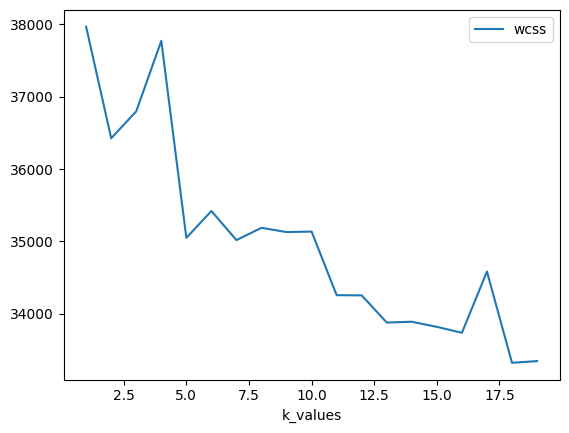

In [176]:
k_values = list(range(1, 20))
wcss = [
    sklearn.cluster.KMeans(n_clusters=k).fit(X).inertia_
    for k in tqdm(k_values)
]

pd.DataFrame({"wcss" : wcss, "k_values": k_values}).plot.line(x="k_values", y="wcss")

15 seems to be a good number of clusters

In [177]:
kmeans = sklearn.cluster.KMeans(n_clusters=15).fit(X)

In [178]:
def create_model():
    return sklearn.cluster.KMeans(n_clusters=15, init="k-means++") 

def train_model(kmeans, X):
    kmeans.fit(X.astype(np.int32))

def get_clusters(kmeans, X):
    clusters = kmeans.predict(X)
    return pd.DataFrame({"userId": get_users(ratings), "cluster" : clusters})

kmeans = create_model()
train_model(kmeans, X)

clusters = get_clusters(kmeans, X)
clusters.groupby(by="cluster").count().rename(columns={"userId": "count"}).T

cluster,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
count,141,1,2,1,1,1,96,1,127,1,1,1,1,208,27


In [179]:
def get_clusters_ratings(clusters, ratings):  
    return pd.merge(left=clusters, right=ratings, on="userId", validate="1:m").groupby(by=["cluster", "movieId"]).agg({"rating": "mean"}).reset_index()

clusters_ratings = get_clusters_ratings(clusters, ratings)
clusters_ratings

,cluster,movieId,rating
0,0,1,3.779412
1,0,2,3.370968
2,0,3,2.000000
3,0,5,2.437500
4,0,6,4.092593
...,...,...,...
22142,14,1517,4.000000
22143,14,1544,2.000000
22144,14,1552,4.000000
22145,14,1639,5.000000


In [180]:
def get_cluster_group_of_user(
    ratings: pd.DataFrame, kmeans: sklearn.cluster.KMeans, users_id: List[int], verbose : bool =False
):

    # merge their ratings
    users_ratings = ratings[ratings["userId"].isin(users_id)].copy()

    # new user id to reprensent the couple (or more people) as a user
    users_ratings["userId"] = 0

    # create user item interation matrix
    X = create_user_item_interaction_matrix_with_only_ratings_only(
        users_ratings, movie_id_to_index, verbose=verbose
    )

    # predict the cluster of this couple
    cluster = kmeans.predict(X)[0]

    return cluster

def default_rating_prediction(ratings : pd.DataFrame, movie_id : int) -> float:
    return ratings[ratings["movieId"] == movie_id].mean()

def predict_rating(
    ratings: pd.DataFrame,
    kmeans: sklearn.cluster.KMeans,
    clusters_ratings: pd.DataFrame,
    movie_id: int,
    users_id: List[int],
    verbose: bool = False,
) -> float:

    log = print if verbose else lambda _: None

    cluster = get_cluster_group_of_user(ratings, kmeans, users_id)
    log(f"Cluster's users is : {cluster}")

    # get the cluster ratings
    cluster_ratings = clusters_ratings[clusters_ratings["cluster"] == cluster]

    # get the rate of the movie given
    movie_ratings = cluster_ratings[cluster_ratings["movieId"] == movie_id]
    if movie_ratings.shape[0] > 0:
        # should have only one rating
        rate = movie_ratings.iloc[0, :]["rating"]
    else:
        log("The movie has not been rated by the cluster")
        log(cluster_ratings["movieId"].sort_values().unique())
        log(cluster_ratings[cluster_ratings["movieId"] == movie_id])
        rate = default_rating_prediction(ratings, movie_id)

    return rate


predict_rating(ratings, kmeans, clusters_ratings, 5, [1, 2], verbose=True)

Cluster's users is : 8


2.6875

In [181]:
def compute_default_ratings_prediction(ratings : pd.DataFrame):
    return ratings.groupby(by="movieId").agg({"rating": "mean"}).reset_index()

default_predictions = compute_default_ratings_prediction(ratings)
default_predictions

,movieId,rating
0,1,3.920930
1,2,3.431818
2,3,3.259615
3,4,2.357143
4,5,3.071429
...,...,...
9719,193581,4.000000
9720,193583,3.500000
9721,193585,3.500000
9722,193587,3.500000


In [182]:
def predict_all_ratings(
    ratings: pd.DataFrame,
    kmeans: sklearn.cluster.KMeans,
    clusters_ratings: pd.DataFrame,
    users_id: List[int],
    default_predictions : pd.DataFrame
):

    cluster = get_cluster_group_of_user(ratings, kmeans, users_id)
    cluster_ratings = clusters_ratings[clusters_ratings["cluster"] == cluster]

    return pd.concat([cluster_ratings[["movieId", "rating"]], default_predictions[~default_predictions["movieId"].isin(cluster_ratings["movieId"])]])

predict_all_ratings(ratings, kmeans, clusters_ratings, [1, 2], default_predictions)

,movieId,rating
8433,1,3.935484
8434,2,3.166667
8435,3,3.023810
8436,4,2.250000
8437,5,2.687500
...,...,...
9719,193581,4.000000
9720,193583,3.500000
9721,193585,3.500000
9722,193587,3.500000


## 4. Recommendation Algorithm (suggest one movie that might be liked by the couple of users)

In [185]:
def suggest_movies(ratings : pd.DataFrame, kmeans, users_id : List[int], n : int) -> List[int]:

    cluster = get_cluster_group_of_user(ratings, kmeans, users_id)

    # get the cluster ratings
    cluster_ratings = clusters_ratings[clusters_ratings["cluster"] == cluster]

    return cluster_ratings.sort_values(by="rating", ascending=False).iloc[:n,:][["movieId", "rating"]]

suggest_movies(ratings, kmeans, [1, 2], 5)

,movieId,rating
15097,140627,5.0
15209,158027,5.0
15150,148671,5.0
9988,2314,5.0
15010,132333,5.0


In [187]:
movies[movies["movieId"].isin(suggest_movies(ratings, kmeans, [1, 2], 5)["movieId"])]

,movieId,title,genres
1722,2314,Beloved (1998),Drama
8839,132333,Seve (2014),Documentary|Drama
9022,140627,Battle For Sevastopol (2015),Drama|Romance|War
9166,148671,Saw (2003),Crime|Horror
9284,158027,SORI: Voice from the Heart (2016),Drama|Sci-Fi


## 5. Evaluation

### Split dataset

In [298]:
r_train, r_test = sklearn.model_selection.train_test_split(ratings, test_size=0.1)

### Regroup functions into a class

In [299]:
pd.DataFrame({"movieId" : ratings["movieId"], "rating": 1})

,movieId,rating
0,1,1
1,3,1
2,6,1
3,47,1
4,50,1
...,...,...
100831,166534,1
100832,168248,1
100833,168250,1
100834,168252,1


In [300]:
r_train["movieId"].unique().shape[0]

9363

In [301]:
r_test["movieId"].unique().shape[0]

3660

In [302]:
ratings["movieId"].unique().shape[0]

9724

In [313]:
class My_Kmeans_Recommender:

    def __init__(self, movie_id_to_index : Dict[int, int]):
        self.movie_id_to_index = movie_id_to_index
        self.kmeans = create_model()
        pass

    def train(self, r_train : pd.DataFrame) -> None:

        self.ratings = r_train
        self.X_train = create_user_item_interaction_matrix_with_only_ratings_only(r_train, movie_id_to_index)
        train_model(self.kmeans, self.X_train)

        self.clusters_ratings_train = get_clusters_ratings(get_clusters(kmeans, self.X_train), r_train)
        self.default_predictions = compute_default_ratings_prediction(r_train)

    def predict(self, movieId_and_userId : pd.DataFrame) -> pd.DataFrame:

        users = get_users(movieId_and_userId)

        all_movies_without_default_predictions = movieId_and_userId[~movieId_and_userId["movieId"].isin(self.default_predictions["movieId"])]["movieId"].unique()
        other_default_ratings = pd.DataFrame({"movieId" : all_movies_without_default_predictions, "rating": self.ratings["rating"].mean()})
        self.default_predictions = pd.concat([self.default_predictions, other_default_ratings])

        predictions = []
        for user_id in tqdm(users, desc="Compute all predictions"):
            predictions_of_one_user = predict_all_ratings(r_train, kmeans, self.clusters_ratings_train, users_id=[user_id], default_predictions=self.default_predictions)
            predictions_of_one_user["userId"] = user_id

            predictions.append(predictions_of_one_user)
        
        predictions = pd.concat(predictions)
        predictions.rename(columns={"rating": "rating_pred"}, inplace=True)

        predictions_merged = pd.merge(left=movieId_and_userId, right=predictions, on=["movieId", "userId"], how="inner", validate="1:1")
        print(predictions_merged.shape[0], movieId_and_userId.shape[0])
        assert predictions_merged.shape[0] == movieId_and_userId.shape[0]

        return predictions_merged

In [314]:
model = My_Kmeans_Recommender(movie_id_to_index)
model.train(r_train)
predictions = model.predict(r_test[["movieId", "userId"]])
predictions

9363
9363
10084 9363
361
9724
9724


Compute all predictions: 100%|██████████| 591/591 [00:02<00:00, 253.88it/s]


10084 10084


,movieId,userId,rating_pred
0,1097,226,3.698413
1,48142,307,4.000000
2,2423,600,3.710526
3,6123,387,3.500309
4,174045,111,3.500309
...,...,...,...
10079,64614,561,3.882353
10080,2424,480,3.265625
10081,8970,10,3.583333
10082,4022,222,3.690141


In [266]:
r2_score = sklearn.metrics.r2_score(y_true=r_test["rating"], y_pred=predictions["rating_pred"])
mean_square = sklearn.metrics.mean_squared_error(y_true=r_test["rating"], y_pred=predictions["rating_pred"])
print(f"mean_square = {mean_square:0.3f}, r2_score = {r2_score:0.3f}")

mean_square = 0.965, r2_score = 0.108


### Evaluate dummy recommander

In [242]:
default_prediction = compute_default_ratings_prediction(r_train)
default_prediction

,movieId,rating
0,1,3.906250
1,2,3.435484
2,3,2.888889
3,4,2.166667
4,5,2.913043
...,...,...
7514,190215,1.500000
7515,190219,1.000000
7516,191005,4.500000
7517,193579,3.500000
